# 11-experiment-three-cogsci

## Analysis

In [1]:
# Analytical Tools
import random
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# General Utilities
import itertools
import json
import pprint

# Custom Utilities
import utilities.plotting as plotting
import utilities.describe as describe

# Some settings
log = pprint.pprint
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.mode.chained_assignment = None

### Import Data & Define Constants

In [2]:
GROUPS = 2
QUESTIONS = 5
JUDGMENTS = 6
SCORE_THRESHOLD = 240.9

data = pd.read_pickle('data/responses.pkl')
data.head()

,id,consent,attention,g0_q0_score,g0_q0_index,g0_q0_j0,g0_q0_j1,g0_q0_j2,g0_q0_j3,g0_q0_j4,...,g1_q4_score,g1_q4_index,g1_q4_j0,g1_q4_j1,g1_q4_j2,g1_q4_j3,g1_q4_j4,g1_q4_j5,j_mean,j_std
0,sana26r21r9md90gqj3o7fm1rm4rpw2p,1,1,36,2,4,3,5,0,5,...,24039,40,3,2,4,5,1,5,3.083333,1.649773
1,68d2brqo4tuf7kstwx0evwcuu5hqf9o2,1,1,30,10,2,2,3,2,2,...,24051,0,1,3,1,1,1,1,2.033333,0.973665
2,rxt9ompoqypdk5v67wmwpseu29te3s08,1,1,14,32,6,2,5,2,3,...,24047,23,2,0,1,6,6,1,3.366667,2.041657
4,wul66ydj8kvrksvrb3u57s0eap457scs,1,1,24,41,5,0,3,4,6,...,24032,42,2,0,4,6,5,4,2.533333,2.417918
5,3lmswywcgo03yave2grh38pyqagaxjqo,1,1,26,20,6,1,3,1,5,...,24052,0,3,0,3,2,1,3,3.066667,2.024148


### Analysis

In [3]:
for g_num in range(GROUPS):
    for j_num in range(JUDGMENTS):
        headings = []
        for q_num in range(QUESTIONS):
            headings.append('g{}_q{}_j{}'.format(g_num, q_num, j_num))
        
        rating_mean = data[headings].mean(axis=1)
        data['g{}_j{}_mean'.format(g_num, j_num)] = rating_mean

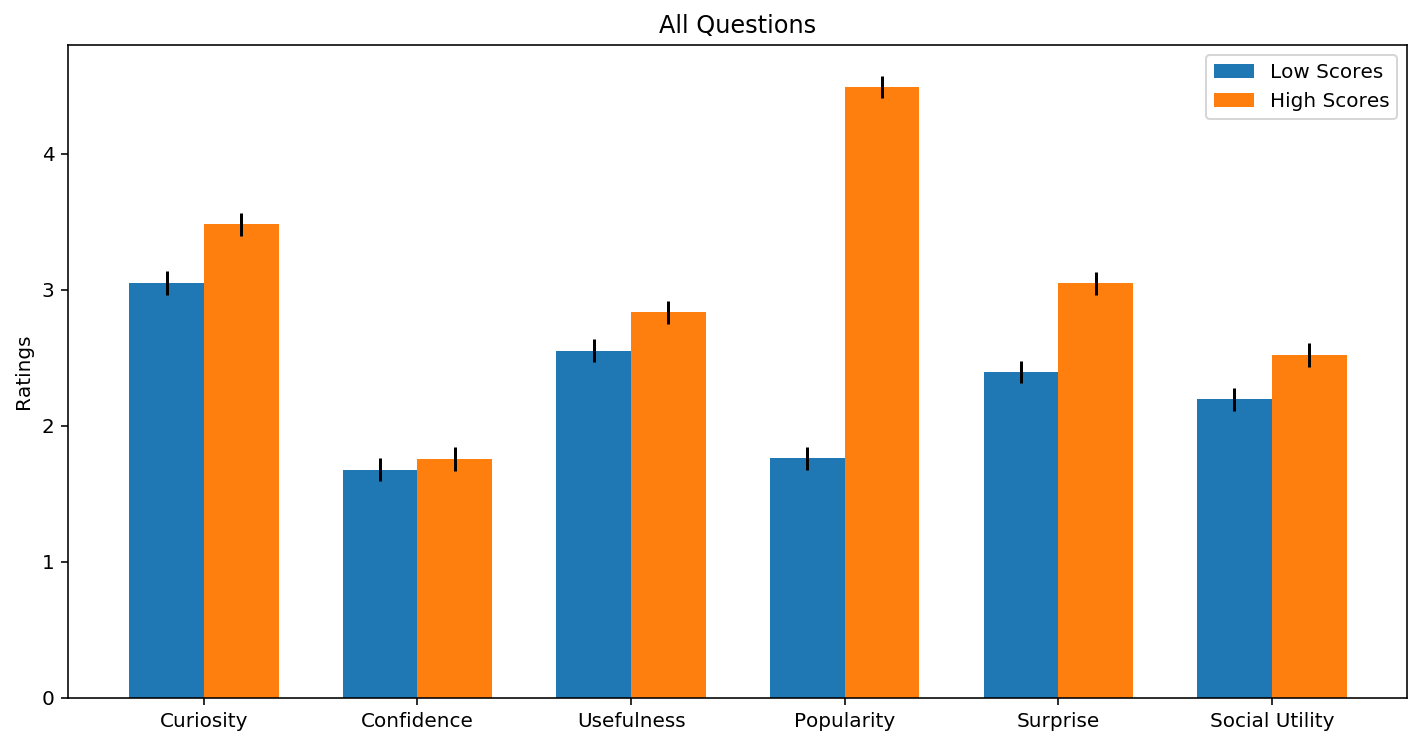

[3.0495798319327743, 1.6756302521008408, 2.5521008403361347, 1.758823529411764, 2.3957983193277324, 2.1932773109243713]
[3.4823529411764693, 1.7529411764705884, 2.8352941176470594, 4.489075630252099, 3.046218487394956, 2.5193277310924374]


In [4]:
PLOTTING_OPTIONS = {
    'ylabel': 'Ratings',
    'ticks': ['Curiosity', 'Confidence', 'Usefulness',
              'Popularity', 'Surprise', 'Social Utility'],
    'legend': ['Low Scores', 'High Scores'],
    'title': 'All Questions',
    'size': (12, 6)
}

# for _ in range(1):
#     sample = data.iloc[random.sample(range(len(data)), len(data))]
    
sample = data

g0_means, g0_errs = [], []
g1_means, g1_errs = [], []
for j_num in range(JUDGMENTS):
    g0_values = sample['g0_j{}_mean'.format(j_num)]
    g1_values = sample['g1_j{}_mean'.format(j_num)]
    g0_means.append(g0_values.mean())
    g1_means.append(g1_values.mean())
    g0_errs.append(stats.sem(g0_values))
    g1_errs.append(stats.sem(g1_values))

plotting.plot_double_bar(
    g0_means, g0_errs, g1_means, g1_errs, 
    **PLOTTING_OPTIONS
)

print(g0_means)
print(g1_means)

In [5]:
print('Low & High')
for j_num in range(JUDGMENTS):
    g0_values = data['g0_j{}_mean'.format(j_num)]
    g2_values = data['g1_j{}_mean'.format(j_num)]
    print('{}: {}'.format(PLOTTING_OPTIONS['ticks'][j_num],
                          describe.paired_t_test(g0_values, g2_values)))

Low & High
Curiosity: t = -5.87, p = 1.47e-08, Δ = 0.433 (1 greater)
Confidence: t = -1.23, p = 0.219, Δ = 0.0773 (1 greater)
Usefulness: t = -4.15, p = 4.68e-05, Δ = 0.283 (1 greater)
Popularity: t = -20.8, p = 2.34e-55, Δ = 2.73 (1 greater)
Surprise: t = -6.32, p = 1.31e-09, Δ = 0.65 (1 greater)
Social Utility: t = -5.08, p = 7.81e-07, Δ = 0.326 (1 greater)


In [17]:
g0_confidences = {num: [] for num in range(7)}
g1_confidences = {num: [] for num in range(7)}
for index, row in data.iterrows():
    for q_num in range(QUESTIONS):
        cur_rating = row['g0_q{}_j0'.format(q_num)] - row['g0_j0_mean']
        conf_rating = row['g0_q{}_j1'.format(q_num)]
        g0_confidences[conf_rating].append(cur_rating)
        
        cur_rating = row['g1_q{}_j0'.format(q_num)] - row['g1_j0_mean']
        conf_rating = row['g1_q{}_j1'.format(q_num)]
        g1_confidences[conf_rating].append(cur_rating)
        
all_confidences = {}
for num in range(7):
    all_confidences[num] = g0_confidences[num] + g1_confidences[num]
# print(sum(sum(all_confidences[num]) for num in all_confidences))

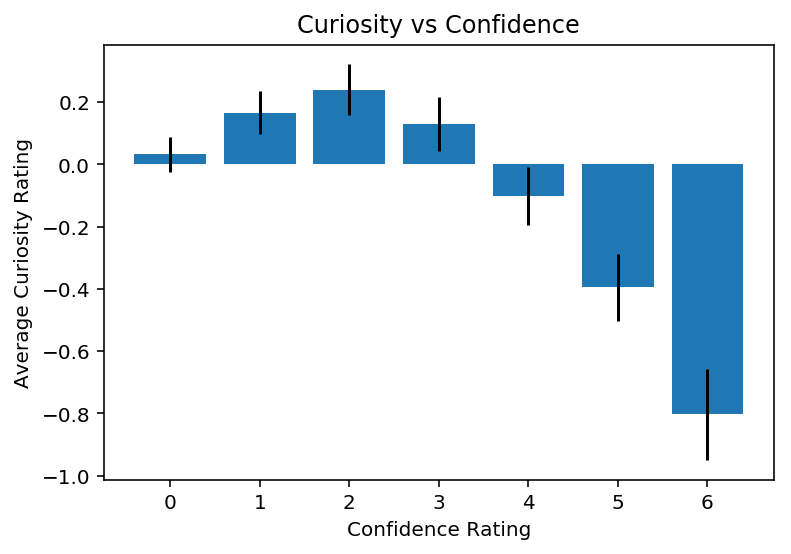

In [41]:
PLOTTING_OPTIONS = {
    'ylabel': 'Average Curiosity Rating',
    'xlabel': 'Confidence Rating',
    'title': 'Curiosity vs Confidence',
}


means = [np.mean(dataset[num]) for num in range(7)]
stderr = [stats.sem(dataset[num]) for num in range(7)]
    
plotting.plot_single_bar(
    means, stderr,
    **PLOTTING_OPTIONS
)
plt.show()

In [74]:
from sklearn import preprocessing

x_values = []
y_values = []
for num in range(7):
    x_values += [num / 6 for _ in range(len(all_confidences[num]))]
    y_values += all_confidences[num]

x_values = np.reshape(np.array(x_values), (-1, 1))
y_values = np.reshape(np.array(y_values), (-1, 1))
x_values_quadratic = preprocessing.PolynomialFeatures(2).fit_transform(x_values)

In [75]:
import statsmodels.api as sm
results = sm.OLS(y_values, x_values_quadratic).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     30.28
Date:                Thu, 18 Apr 2019   Prob (F-statistic):           1.03e-13
Time:                        16:51:29   Log-Likelihood:                -4409.6
No. Observations:                2380   AIC:                             8825.
Df Residuals:                    2377   BIC:                             8843.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0321      0.047      0.682      0.495      -0.060       0.124
x1             1.2238      0.320      3.829      0.000       0.597       1.851
x2            -2.0748      0.362     -5.738      0.000      -2.784      -1.366
==============================================================================
Omnibus:                        4.076   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                4.046
Skew:                          -0.101   Prob(JB):                        0.132
Kurtosis:                       3.014   Cond. No.                         16.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
result = results.params

print('Best Polynomial')
print('y = {:.4}x^2 + {:.4}x + {:.4}'.format(result[2], result[1], result[0]))
print('y = {:.4}x(1 - x) + {:.4}x '.format(-result[2], result[1] + result[2], result[0]))

Best Polynomial
y = -2.075x^2 + 1.224x + 0.03208
y = 2.075x(1 - x) + -0.851x 


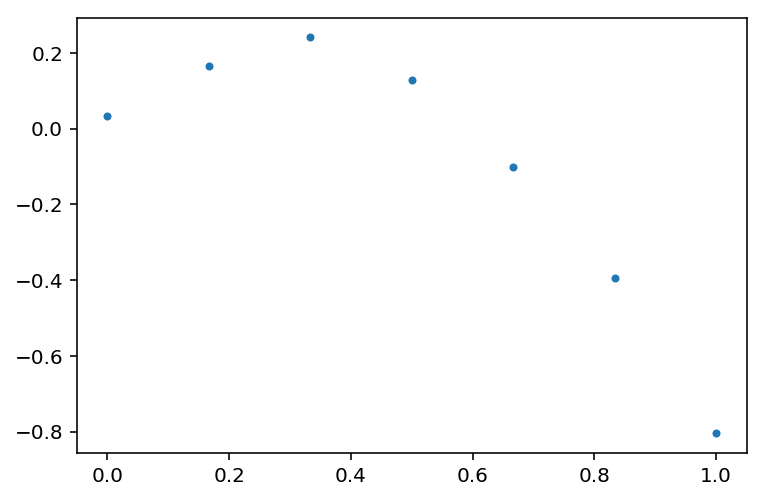

In [78]:
poly = np.poly1d(reversed(result))
x_ticks = np.linspace(0, 1, 100)
plt.plot(np.linspace(0, 1, 7), means, '.')
plt.plot(np.linspace(0, 1, 7), means, '.')
plt.show()